# Null Model Validation & H3 Equity Analysis


## Part 1: Statistical Validation of H1

In Notebook 02, we found that Thames crossings carry **8.6% of CRREB mass on 3.2% of edges**, a 2.7× over-representation. But is this statistically significant, or could it occur by chance?

**Question:** If we randomly selected 15 edges with the *same length distribution* as actual crossings, would they carry similar CRREB mass?

**Method:** Matched random-set null model with 1,000 iterations.

## Part 2: Equity Analysis (H3)

**Hypothesis 3 (H3):** Areas with higher deprivation face greater exposure to Thames crossing vulnerability.

**Question:** Do more deprived neighbourhoods (LSOAs) have:
- Higher baseline cross-river penalty (CRP)?
- Greater exposure to crossing disruption (max ΔCRP from resilience scenarios)?

**Method:** Link LSOA centroids to nearest stations; correlate station metrics with Index of Multiple Deprivation (IMD).


In [1]:
from __future__ import annotations

import logging
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
from src.core.config import SEED, configure_logging, get_paths
from src.geo.equity import build_station_kdtree_bng, assign_nearest_station, distance_to_centre_m

In [3]:
LOGGER = logging.getLogger("h3_null_and_equity")

In [ ]:
configure_logging()
paths = get_paths()

out_dir = paths.data_analysis / "04_h3_equity_analysis"
out_dir.mkdir(parents=True, exist_ok=True)

In [5]:
n_null = 1000
q_bins = 5
seed = int(SEED)
exclude_zone1 = False

### **Null model (CRREB concentration)** 

### The Problem with Simple Comparisons

In Notebook 02, it was noted that crossings carry 2.7× their proportional share of CRREB mass. But this could be explained by a confound:

> **Crossings are long edges** (they span the river). Long edges might naturally carry more CRREB simply because they cover more distance. If we compared crossings to *random* edges, we'd be comparing long edges to short edges.

### The Solution: Matched Random-Set Null Model

I construct a null distribution by:

1. **Bin all edges by length** (5 distance quintiles)
2. **Count how many crossings fall in each bin**
3. **For each null iteration:**
   - Sample the same number of *non-crossing* edges from each bin
   - Sum their CRREB values
4. **Compare observed crossing CRREB to null distribution**

This answers: **"Is crossing CRREB concentration higher than expected for edges of similar length?"**

### Other Considered Approaches

| Alternative Design | Problem | Our Solution |
|--------------------|---------|--------------|
| Simple label permutation | Permutes crossing labels to edges with different lengths → "impossible worlds" | Match on length bins |
| Random edge sampling | Doesn't control for length confound | Stratified sampling by distance quintile |
| Parametric test | Assumes distribution shape | Non-parametric (empirical p-value) |

### Test Statistic

$$S = \sum_{e \in \text{selected edges}} \text{CRREB}(e)$$

- **Observed**: $S_{\text{obs}}$ = sum of CRREB on the 15 actual crossings
- **Null**: $S_{\text{null}}^{(i)}$ = sum of CRREB on 15 distance-matched non-crossings (iteration $i$)

### P-Value Calculation

$$p = \frac{\#\{S_{\text{null}}^{(i)} \geq S_{\text{obs}}\} + 1}{N + 1}$$

In [6]:
crreb = pd.read_csv(paths.processed_metrics / "crreb_edges.csv", dtype={"u": "string", "v": "string"})

In [7]:
crossing_mask = crreb["is_thames_crossing"].fillna(False)

In [8]:
crreb = (
    crreb.assign(
        _is_crossing=crossing_mask.astype(bool).values,
        crreb=lambda df: pd.to_numeric(df["crreb"], errors="coerce"),
        distance_m=lambda df: pd.to_numeric(df["distance_m"], errors="coerce"),
    )
    .dropna(subset=["crreb", "distance_m"])
    .reset_index(drop=False)
    .rename(columns={"index": "_row_index"})
    .assign(
        _bin=lambda df: pd.qcut(
            df["distance_m"], q=q_bins, labels=False, duplicates="drop"
        ).astype("Int64")
    )
    .dropna(subset=["_bin"])
    .assign(_bin=lambda df: df["_bin"].astype(int))
)

In [9]:
crossings = crreb[crreb["_is_crossing"]]
noncross = crreb[~crreb["_is_crossing"]]
n_cross = int(crossings.shape[0])

In [10]:
n_cross

15

In [11]:
req = crossings["_bin"].value_counts().to_dict()
bins = sorted(set(crreb["_bin"].tolist()))
n_bins = len(bins)

In [12]:
n_bins

5

In [13]:
rng = np.random.default_rng(seed)
used_replacement = False

s_null = np.zeros(n_null, dtype=float)
sampled_rows = []

# Precompute noncross indices by bin for speed
pool_by_bin = {}
for b in bins:
    pool = noncross.loc[noncross["_bin"] == b, "_row_index"].to_numpy()
    pool_by_bin[b] = pool

In [14]:
crreb

,_row_index,u,v,crreb,distance_m,line_ids,modes,is_thames_crossing,_is_crossing,_bin
0,0,1000002,1000048,43.500000,1290.600047,district,tube,False,False,2
1,1,1000002,1000063,1154.983333,958.119398,district;piccadilly,tube,False,False,1
2,2,1000002,1000208,694.750000,1881.111402,piccadilly,tube,False,False,4
3,3,1000002,1000240,720.233333,1996.558081,piccadilly,tube,False,False,4
4,4,1000048,1000240,17.500000,923.886792,district,tube,False,False,1
...,...,...,...,...,...,...,...,...,...,...
462,462,1002025,1002074,2114.000000,494.636299,dlr,dlr,False,False,0
463,463,1002048,1002061,1731.000000,463.965258,dlr,dlr,False,False,0
464,464,1002046,1002074,2446.000000,520.729644,dlr,dlr,False,False,0
465,465,1002046,1003008,2493.000000,181.001889,dlr,dlr,False,False,0


In [15]:
crreb_index_1d = crreb["_row_index"]
crreb_crreb_1d = crreb["crreb"]

values_by_row = dict(zip(crreb_index_1d.tolist(), crreb_crreb_1d.tolist()))

for it in range(n_null):
    picked = []
    for b, k in req.items():
        pool = pool_by_bin.get(int(b), np.array([], dtype=int))
        if pool.size == 0:
            used_replacement = True
            continue
        if pool.size < int(k):
            used_replacement = True
            choice = rng.choice(pool, size=int(k), replace=True)
        else:
            choice = rng.choice(pool, size=int(k), replace=False)
        picked.extend([int(x) for x in choice.tolist()])
    # If, due to empty bins, we sampled fewer than n_cross, top up from all noncross
    if len(picked) < n_cross:
        used_replacement = True
        remaining = n_cross - len(picked)
        all_pool = noncross["_row_index"].to_numpy()
        top = rng.choice(all_pool, size=int(remaining), replace=True)
        picked.extend([int(x) for x in top.tolist()])

    # Compute statistic
    s = 0.0
    for ridx in picked:
        v = values_by_row.get(ridx)
        if v is not None and np.isfinite(float(v)):
            s += float(v)
    s_null[it] = s
    sampled_rows.append({"iter": it, "sampled_row_indices": ",".join(map(str, picked))})

s_obs = float(crossings["crreb"].sum())
p_val = float((np.sum(s_null >= s_obs) + 1) / (n_null + 1))

1,000 iterations of matched random sampling completed. Each iteration:
1. Sampled 15 non-crossing edges matching the crossing length distribution
2. Summed their CRREB values
3. Stored the sum as one null observation

I now compare the observed crossing CRREB to this null distribution.

In [16]:
s_obs, p_val

(23476.078047391195, 0.000999000999000999)

In [17]:
samples_df = pd.DataFrame(sampled_rows)

In [18]:
samples_df.head()

,iter,sampled_row_indices
0,0,"367,71,288,18,255,299,16,415,332,453,63,267,46..."
1,1,"201,367,432,314,374,255,246,349,274,341,332,46..."
2,2,"275,314,264,2,308,336,252,34,332,24,206,441,27..."
3,3,"179,275,384,199,117,212,301,326,295,61,335,221..."
4,4,"275,62,430,28,349,107,304,313,41,243,57,157,28..."


**Null model Summary**

In [19]:
print(
    f"n_null: {n_null}\n"
    f"n_obs crossings: {n_cross}\n"
    f"s_obs: {s_obs:.3f}\n"
    f"s_null mean: {np.mean(s_null):.3f}\n"
    f"s_null std: {np.std(s_null):.3f}\n"
    f"empirical p-value: {p_val:.5f}\n"
)


n_null: 1000
n_obs crossings: 15
s_obs: 23476.078
s_null mean: 8532.552
s_null std: 3200.913
empirical p-value: 0.00100



### Null Model Results

| Statistic | Value |
|-----------|-------|
| **Observed CRREB (crossings)** | 23,476 |
| **Null mean** | 8,533 |
| **Null std** | 3,201 |
| **Standardized gap** | (23,476 - 8,533) / 3,201 = **4.7σ** |
| **Empirical p-value** | **0.001** (floor at 1/1001) |

### Interpretation

The observed CRREB concentration on crossings is **4.7 standard deviations above** what we'd expect from length-matched random edges. The empirical p-value of 0.001 is at the floor (no null samples exceeded observed), indicating:

> **p < 0.001**: The CRREB concentration on Thames crossings is highly statistically significant, even after controlling for edge length.

This validates the H1 finding from Notebook 02: crossings don't just carry high CRREB because they're long edges. They carry high CRREB because they're **crossings**.

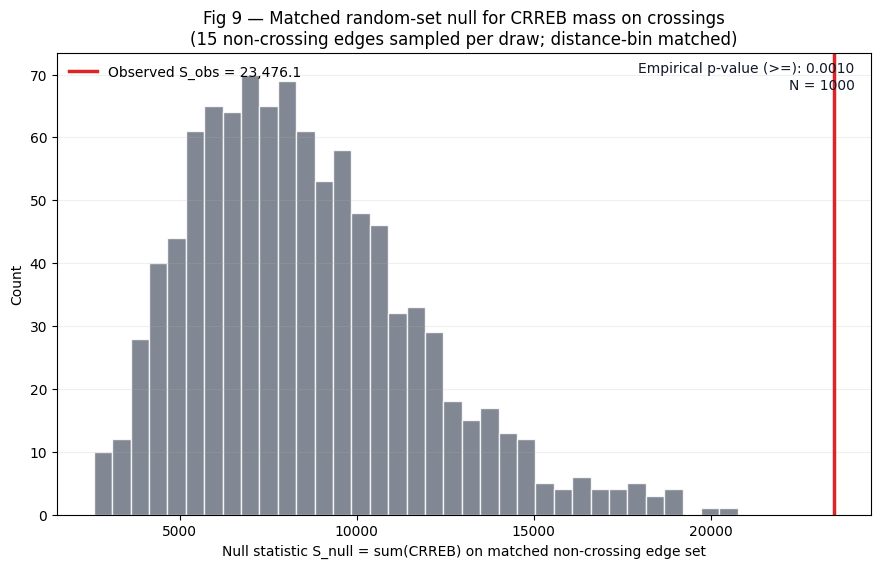

In [20]:
fig, ax = plt.subplots(figsize=(10.5, 6.0))
ax.hist(s_null, bins=35, color="#6b7280", alpha=0.85, edgecolor="white")
ax.axvline(s_obs, color="#dc2626", lw=2.5, label=f"Observed S_obs = {s_obs:,.1f}")
ax.set_title(
    "Fig 9 — Matched random-set null for CRREB mass on crossings\n"
    "(15 non-crossing edges sampled per draw; distance-bin matched)"
)
ax.set_xlabel("Null statistic S_null = sum(CRREB) on matched non-crossing edge set")
ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.2)

txt = f"Empirical p-value (>=): {p_val:.4f}\nN = {len(s_null)}"
ax.text(
    0.98,
    0.98,
    txt,
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    color="#111827",
)

ax.legend(loc="upper left", frameon=False)
plt.show()

This histogram shows:
- **Gray bars**: Distribution of CRREB sums from 1,000 matched random edge sets
- **Red line**: Observed CRREB sum on actual crossings (23,476)

**Key observation:** The observed value is far to the right of the entire null distribution. No null sample approached the observed value, hence p < 0.001.

### **Equity Analysis**

#### Part 2: Equity Analysis (H3)
Does Thames crossing vulnerability fall disproportionately on deprived areas?


| Variable | Source | Interpretation |
|----------|--------|----------------|
| **IMD decile** | Index of Multiple Deprivation 2019 | 1 = most deprived, 10 = least deprived |
| **CRP** | Notebook 02 | Station's baseline cross-river penalty |
| **Max ΔCRP** | Notebook 03 | Station's worst-case disruption (max across scenarios) |
| **Distance to centre** | Charing Cross | Control for spatial confounding |

**Hypothesis**

If the Thames barrier disproportionately affects deprived areas, we expect:
- **Negative correlation**: Higher deprivation (low IMD) → higher CRP/disruption

**Potential Confound: Spatial Structure**

London's deprivation follows a spatial pattern: outer boroughs tend to be less deprived than inner east London. Cross-river metrics also have spatial structure. I include **distance-to-centre** as a control.

#### Data Sources

**LSOA Centroids:**  
Lower Layer Super Output Areas (2021 boundaries) — 5,126 LSOAs in Greater London.

**Index of Multiple Deprivation (IMD 2019):**  
Official deprivation measure combining income, employment, education, health, crime, housing, and environment indicators. Decile 1 = most deprived 10% nationally.

**Station Metrics:**  
CRP and max disruption penalty from Notebooks 02 and 03.

In [21]:
lsoa_geo = paths.processed_boundaries / "lsoa_london.geojson"
imd_csv = paths.processed_boundaries / "imd_2025_london.csv"
stations_csv = paths.processed_transit / "stations_london.csv"
bank_csv = paths.processed_spatial / "station_bank.csv"
crp_csv = paths.processed_metrics / "crp_nodes.csv"
penalties_csv = paths.data_processed / "station_disruption_penalties.csv"

In [22]:
centre_lon = -0.1246
centre_lat = 51.5079
centre_name = "Charing Cross"

In [23]:
def _load_lsoa_centroids(paths) -> pd.DataFrame:
    gdf = gpd.read_file(paths.processed_boundaries / "lsoa_london.geojson")
    cols = [
        c
        for c in gdf.columns
        if c.upper() in ("LSOA21CD", "LSOA21NM", "BNG_E", "BNG_N", "LAT", "LONG")
    ]
    df = pd.DataFrame(gdf[cols]).copy()
    df = df.rename(
        columns={
            "LSOA21CD": "lsoa21cd",
            "LSOA21NM": "lsoa21nm",
            "BNG_E": "bng_e",
            "BNG_N": "bng_n",
            "LAT": "lat",
            "LONG": "lon",
        }
    )
    return df

def _load_imd(paths) -> pd.DataFrame:
    imd = pd.read_csv(paths.processed_boundaries / "imd_2025_london.csv")
    imd = imd.rename(
        columns={
            "LSOA code (2021)": "lsoa21cd",
            "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile",
            "Income Decile (where 1 is most deprived 10% of LSOAs)": "income_decile",
        }
    )
    keep = ["lsoa21cd", "imd_decile", "income_decile"]
    missing = [c for c in keep if c not in imd.columns]
    if missing:
        raise ValueError(f"imd_2025_london.csv missing expected columns: {missing}")
    imd = imd[keep].copy()
    imd["lsoa21cd"] = imd["lsoa21cd"].astype(str)
    imd["imd_decile"] = pd.to_numeric(imd["imd_decile"], errors="coerce")
    imd["income_decile"] = pd.to_numeric(imd["income_decile"], errors="coerce")
    return imd


LSOA-Station Linkage

Each LSOA centroid is assigned to its **nearest transit station** (Euclidean distance in BNG coordinates). The LSOA then "inherits" that station's:
- CRP (baseline cross-river penalty)
- Max disruption penalty (worst-case ΔCRP from resilience scenarios)

**Limitation:** This is a simple proximity assignment. In reality, residents may use multiple stations or non-nearest stations. This is a first-order approximation.

**Distance-to-centre:** Computed from LSOA centroid to Charing Cross (central London reference point). Used to visualize and control for spatial structure.

In [24]:
lsoa = _load_lsoa_centroids(paths)
imd = _load_imd(paths)

stations = pd.read_csv(stations_csv, dtype={"station_id": "string"})
station_bank = pd.read_csv(bank_csv, dtype={"station_id": "string"})
crp_nodes = pd.read_csv(crp_csv, dtype={"station_id": "string"})
penalties = pd.read_csv(penalties_csv, dtype={"station_id": "string"})

In [25]:
zone_suffix = ""
if exclude_zone1:
    z = pd.to_numeric(stations.get("zone"), errors="coerce")
    keep = ~(z == 1)
    n_before = int(stations.shape[0])
    stations = stations.loc[keep].copy()
    zone_suffix = "_zone2plus"
    LOGGER.info(
        "Zone 1 exclusion enabled: stations kept=%s (dropped=%s of %s)",
        int(stations.shape[0]),
        n_before - int(stations.shape[0]),
        n_before,
    )

In [26]:
lsoa["lsoa21cd"] = lsoa["lsoa21cd"].astype(str)
imd["lsoa21cd"] = imd["lsoa21cd"].astype(str)

 #  Nearest station assignment
tree, st_xy = build_station_kdtree_bng(stations)
lsoa = assign_nearest_station(lsoa, st_xy, tree)

# Join station metrics
crp_nodes = crp_nodes[["station_id", "crp"]]
penalties = penalties[["station_id", "delta_crp_max"]] # max disruption penalty proxy: max ΔCRP across scenarios
station_bank = station_bank[["station_id", "bank"]]

lsoa_equity_frame = (
    lsoa
    .merge(crp_nodes, left_on="nearest_station_id", right_on="station_id", how="left")
    .merge(penalties, on="station_id", how="left")
    .merge(station_bank, on="station_id", how="left")
    .rename(
        columns={
            "station_id": "nearest_station_id_join",
            "delta_crp_max": "disruption_penalty_max_dcrp",
        }
    )
    .drop(columns=["nearest_station_id_join"])
    .merge(imd, on="lsoa21cd", how="left")
)

# Distances to centre
lsoa_equity_frame["dist_to_centre_m"] = distance_to_centre_m(
    lsoa_equity_frame,
    centre_lon=centre_lon,
    centre_lat=centre_lat,
)

In [27]:
lsoa_equity_frame.head()

,lsoa21cd,lsoa21nm,bng_e,bng_n,lat,lon,nearest_station_id,dist_to_nearest_station_m,crp,disruption_penalty_max_dcrp,bank,imd_decile,income_decile,dist_to_centre_m
0,E01000001,City of London 001A,532123,181632,51.51817,-0.097150,1000014,241.270662,1.042085,0.701933,north,8,10,2219.909687
1,E01000002,City of London 001B,532480,181715,51.51883,-0.091970,1000149,265.301697,-0.038757,0.718326,north,10,10,2568.606528
2,E01000003,City of London 001C,532239,182033,51.52174,-0.095330,1000014,243.482289,1.042085,0.701933,north,8,8,2547.903146
3,E01000005,City of London 001E,533581,181283,51.51469,-0.076280,1000003,68.474817,0.725618,0.704918,north,5,5,3436.272411
4,E01000006,Barking and Dagenham 016A,544994,184274,51.53875,0.089317,1000015,576.440940,1.651725,0.546905,north,4,3,15234.585076


In [ ]:
out_frame = out_dir / f"lsoa_equity_frame{zone_suffix}.csv"
lsoa_equity_frame.to_csv(out_frame, index=False)

In [29]:
lsoa_equity_frame["dist_centre_quintile"] = (
    pd.qcut(lsoa_equity_frame["dist_to_centre_m"], q=5, labels=False, duplicates="drop") + 1
)

palette = ["#1d4ed8", "#2563eb", "#60a5fa", "#93c5fd", "#bfdbfe"]
colors = lsoa_equity_frame["dist_centre_quintile"].map(
    lambda q: palette[int(q) - 1] if pd.notna(q) else "#6b7280"
)

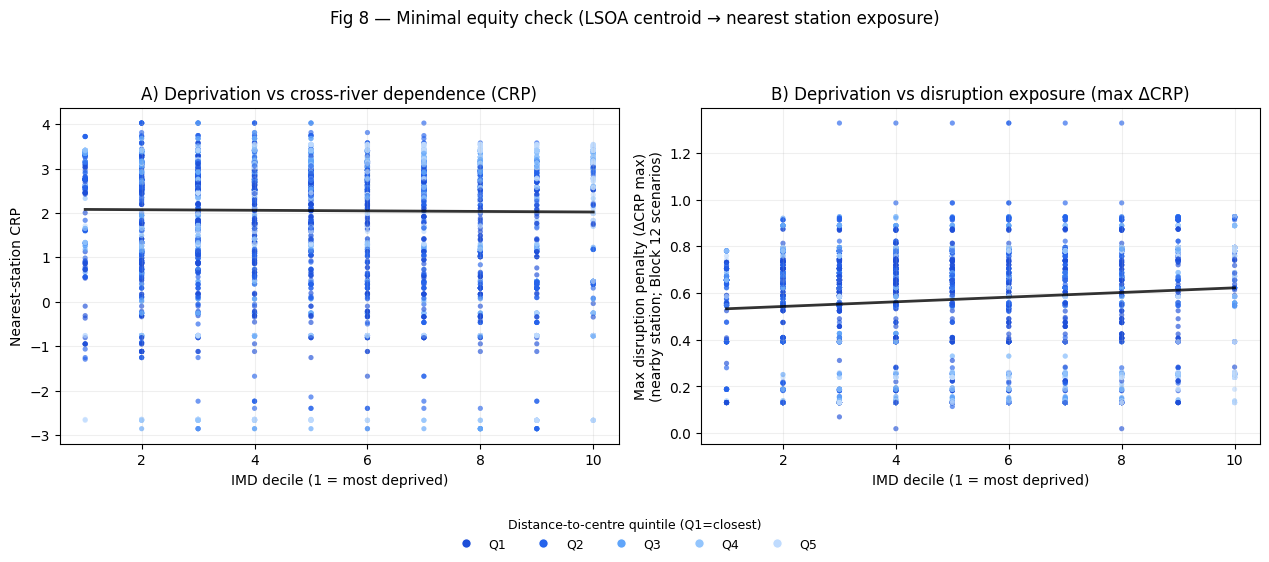

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12.8, 5.6))

ax = axes[0]
ax.scatter(lsoa_equity_frame["imd_decile"], lsoa_equity_frame["crp"], c=colors, s=14, alpha=0.65, edgecolor="none")
x = lsoa_equity_frame["imd_decile"].to_numpy(dtype=float)
y = lsoa_equity_frame["crp"].to_numpy(dtype=float)
coef = np.polyfit(x, y, deg=1)
xx = np.linspace(x.min(), x.max(), 100)
ax.plot(xx, coef[0] * xx + coef[1], color="black", lw=2, alpha=0.8)
ax.set_xlabel("IMD decile (1 = most deprived)")
ax.set_ylabel("Nearest-station CRP")
ax.set_title("A) Deprivation vs cross-river dependence (CRP)")
ax.grid(alpha=0.2)

ax = axes[1]
ax.scatter(
    lsoa_equity_frame["imd_decile"],
    lsoa_equity_frame["disruption_penalty_max_dcrp"],
    c=colors,
    s=14,
    alpha=0.65,
    edgecolor="none",
)
x = lsoa_equity_frame["imd_decile"].to_numpy(dtype=float)
y = lsoa_equity_frame["disruption_penalty_max_dcrp"].to_numpy(dtype=float)
coef = np.polyfit(x, y, deg=1)
xx = np.linspace(x.min(), x.max(), 100)
ax.plot(xx, coef[0] * xx + coef[1], color="black", lw=2, alpha=0.8)
ax.set_xlabel("IMD decile (1 = most deprived)")
ax.set_ylabel("Max disruption penalty (ΔCRP max)\n(nearby station; Block 12 scenarios)")
ax.set_title("B) Deprivation vs disruption exposure (max ΔCRP)")
ax.grid(alpha=0.2)

handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=palette[i],
        markersize=7,
        label=f"Q{i + 1}",
    )
    for i in range(len(palette))
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=5,
    frameon=False,
    title="Distance-to-centre quintile (Q1=closest)",
    fontsize=9,
    title_fontsize=9,
)

fig.suptitle("Fig 8 — Minimal equity check (LSOA centroid → nearest station exposure)", y=0.98)
fig.tight_layout(rect=[0, 0.10, 1, 0.93])
plt.show()    

**Correlations**

In [31]:
rows: list[dict[str, object]] = []
pairs = [
    ("imd_decile", "crp", "IMD decile vs CRP"),
    (
        "imd_decile",
        "disruption_penalty_max_dcrp",
        "IMD decile vs max disruption penalty (ΔCRP max)",
    ),
    ("imd_decile", "dist_to_centre_m", "IMD decile vs distance to centre"),
]

for a, b, label in pairs:
    sub = lsoa_equity_frame[[a, b]].dropna()
    if sub.empty:
        continue
    r, rp = stats.pearsonr(sub[a], sub[b])
    rho, rhop = stats.spearmanr(sub[a], sub[b])
    rows.append(
        {
            "comparison": label,
            "n": int(sub.shape[0]),
            "pearson_r": float(r),
            "pearson_p": float(rp),
            "spearman_rho": float(rho),
            "spearman_p": float(rhop),
        }
    )

correlations = pd.DataFrame(rows)

In [32]:
correlations

,comparison,n,pearson_r,pearson_p,spearman_rho,spearman_p
0,IMD decile vs CRP,5126,-0.011894,3.945658e-01,0.040594,3.651165e-03
1,IMD decile vs max disruption penalty (ΔCRP max),5126,0.116343,6.482735e-17,0.159049,2.156288e-30
2,IMD decile vs distance to centre,5126,0.214191,2.885185e-54,0.198450,1.101563e-46


**H3 Verdict: Not Supported (Clean Null)**

1. **CRP-IMD correlation is essentially zero** (r = -0.012, p = 0.39)
   - No evidence that deprived areas have worse baseline cross-river accessibility
   - This is a clean null result

2. **Disruption-IMD correlation is positive** (r = +0.116, p < 0.001)
   - This means LESS deprived areas have HIGHER disruption exposure
   - **Counterintuitive**: opposite to equity concern
   - Likely explained by spatial confounding (next point)

3. **Distance-to-centre is the dominant correlate** (r = +0.214)
   - IMD correlates more strongly with location than with transit metrics
   - Outer London is less deprived AND has different transit topology
   - The disruption-IMD correlation is likely a proxy for location

### Limitations

| Limitation | Impact |
|------------|--------|
| Nearest-station assignment | May not reflect actual travel patterns |
| Topology-only metrics | Doesn't capture crowding, frequency, reliability |
| IMD is area-level | Ecological fallacy risk |
| No causal identification | Correlational only |